# **Convulotional Neural Networks**

The followings code are inspired from
"Image Preparation for Convolutional Neural Networks with TensorFlow's Keras API" video by deeplizard

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter (action='ignore', category=FutureWarning)
%matplotlib inline

print(np.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1.23.5


In [2]:
# Check for available GPUs and set memory growth for the first GPU

# List all available physical devices (including GPUs)
physical_devices = tf.config.experimental.list_physical_devices('GPU')

# Print the number of available GPUs
print("Num GPUs Available: ", len(physical_devices))

# Set memory growth for the first GPU (assuming at least one GPU is available)
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available:  1


# **Data preparation**

In [3]:
# Change the current working directory to '/kaggle/working'
os.chdir('/kaggle/working')

# Define the source directory where the dataset is located
source_directory = '/kaggle/input/catdog-dataset/dogs-and-cats'

# Check if a directory named 'dogcat_dataset' does not exist
if os.path.isdir('dogcat_dataset') is False:
    # If 'dogcat_dataset' does not exist, copy the contents of 'source_directory' to 'dogcat_dataset'
    shutil.copytree(source_directory, 'dogcat_dataset')


In [4]:
# Define paths for training, validation, and test sets
train_path = '/kaggle/working/dogcat_dataset/train'
valid_path = '/kaggle/working/dogcat_dataset/valid'
test_path = '/kaggle/working/dogcat_dataset/test'

# Check if the directories exist and print the results
print(os.path.isdir(train_path))  # Check if 'train' directory exists
print(os.path.isdir(valid_path))  # Check if 'valid' directory exists
print(os.path.isdir(test_path))   # Check if 'test' directory exists


True
True
True


In [5]:
# Define ImageDataGenerator and generate batches of images

# Training set
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

# Validation set
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

# Test set
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)


Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [6]:
# Assertions to validate properties of the generated batches

# Ensure that there are 2000 images in the training set
assert train_batches.n == 2000

# Ensure that there are 400 images in the validation set
assert valid_batches.n == 400

# Ensure that there are 200 images in the test set
assert test_batches.n == 200

# Ensure that the number of classes is 2 for all sets (cat and dog)
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2


In [7]:
# Generate a batch of images and their corresponding labels

# Use the 'next' method to get the next batch of images and labels from the training set
imgs, labels = next(train_batches)


In [8]:
# Define a function to plot a series of images

def plotImages(images_arr):
    # Create a figure with 10 subplots arranged in 1 row and 10 columns
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    
    # Flatten the array of axes to make it easier to iterate over
    axes = axes.flatten()
    
    # Iterate through the images and corresponding axes
    for img, ax in zip(images_arr, axes):
        # Display the image on the current axis
        ax.imshow(img)
        
        # Turn off axis labels for better visualization
        ax.axis('off')
    
    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    
    # Display the figure with the images
    plt.show()


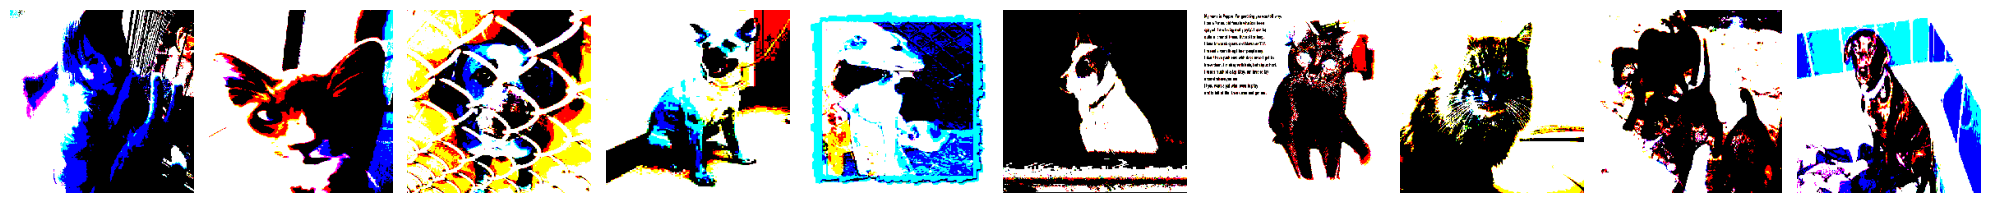

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [9]:
# Plot the images in 'imgs' and print the corresponding labels

# Call the previously defined function 'plotImages' to display the images
plotImages(imgs)

# Print the labels corresponding to the displayed images
print(labels)


# **Build and Train a CNN**

The followings code are inspired from "Build and Train a Convolutional Neural Network with TensorFlow's Keras API" video by deeplizard

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import matplotlib.pyplot as plt

In [11]:
# Define a Sequential model
model = Sequential([
    # First convolutional layer
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    
    # Max pooling layer to reduce spatial dimensions
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    # Second convolutional layer
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    
    # Max pooling layer to further reduce spatial dimensions
    MaxPool2D(pool_size=(2, 2), strides=2),
    
    # Flatten layer to convert 2D feature maps into 1D vector
    Flatten(),
    
    # Fully connected dense layer with 2 units and softmax activation for classification
    Dense(units=2, activation='softmax')
])


In [12]:
# Display a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
# Train the model
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
200/200 - 13s - loss: 37.2261 - accuracy: 0.5620 - val_loss: 13.2427 - val_accuracy: 0.7025 - 13s/epoch - 67ms/step
Epoch 2/10
200/200 - 6s - loss: 14.0576 - accuracy: 0.6880 - val_loss: 5.4991 - val_accuracy: 0.8225 - 6s/epoch - 28ms/step
Epoch 3/10
200/200 - 5s - loss: 9.3269 - accuracy: 0.7595 - val_loss: 11.7035 - val_accuracy: 0.7250 - 5s/epoch - 27ms/step
Epoch 4/10
200/200 - 6s - loss: 3.5539 - accuracy: 0.8480 - val_loss: 4.4027 - val_accuracy: 0.8625 - 6s/epoch - 31ms/step
Epoch 5/10
200/200 - 5s - loss: 2.1216 - accuracy: 0.8950 - val_loss: 0.7357 - val_accuracy: 0.9550 - 5s/epoch - 27ms/step
Epoch 6/10
200/200 - 5s - loss: 2.1395 - accuracy: 0.9035 - val_loss: 1.3636 - val_accuracy: 0.9350 - 5s/epoch - 27ms/step
Epoch 7/10
200/200 - 5s - loss: 1.5890 - accuracy: 0.9145 - val_loss: 1.0389 - val_accuracy: 0.9475 - 5s/epoch - 27ms/step
Epoch 8/10
200/200 - 6s - loss: 1.0897 - accuracy: 0.9380 - val_loss: 0.7940 - val_accuracy: 0.9650 - 6s/epoch - 28ms/step
Epoch 9/10

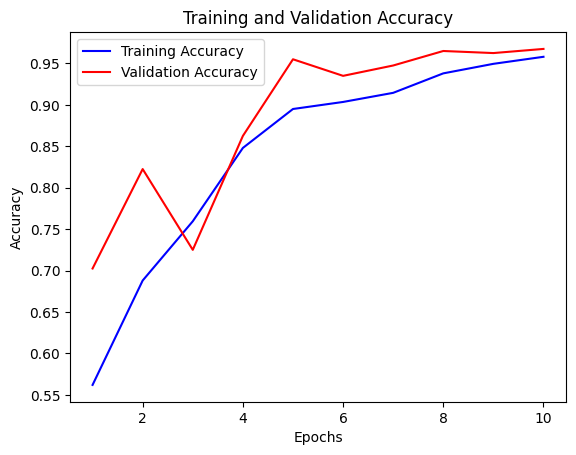

In [15]:
# Retrieve training and validation accuracy from the training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a list of epochs for the x-axis
epochs = range(1, len(train_accuracy) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')  # Blue line for training accuracy
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')  # Red line for validation accuracy

# Add title and labels to the plot
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Add a legend to differentiate between training and validation accuracy
plt.legend()

# Show the plot
plt.show()
